In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import json

In [3]:
from data_utils import StravaDataHandler, FitbitDataHandler

In [4]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

## Helper Functions

Evaluation function used to evaluate the accuracy of the trained models.

In [41]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Get Fitbit Sleep Data

In [6]:
fb_handler = FitbitDataHandler(sleep_dir='./Sleep',
                              heart_rate_df='Sleep/sleep_score.csv')

In [7]:
sleep_jsons = fb_handler.generate_file_list()

In [8]:
fb_handler.load_sleep_df(sleep_jsons)

In [9]:
fb_handler.sleep_df.head()

,date,deep,wake,light,rem
44,2017-12-17,40,69,188,73
43,2017-12-18,53,66,208,115
42,2017-12-19,57,73,208,138
11,2019-07-08,55,83,281,64
10,2019-07-09,57,59,239,38


### Set Up Heart Rate Data

In [10]:
fb_handler.initialize_hr_df()

In [11]:
fb_handler.heart_rate_df.head()

,date,overall_score,resting_heart_rate
44,2017-12-17,72,64
43,2017-12-18,81,61
42,2017-12-19,76,60
11,2019-07-08,74,56
10,2019-07-09,83,58


## Set Up Strava Data

In [12]:
strava_handler = StravaDataHandler(csv_path='./stravadata.csv')

In [13]:
strava_handler.csv_to_df()

In [14]:
strava_handler.df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local
0,3.489,180.6,NaN,9930.8,0:47:26,86.0,Run,2020-09-23T18:30:44
1,3.595,170.0,NaN,7746.9,0:35:55,81.0,Run,2020-09-21T17:57:51
2,7.588,150.9,126.4,74781.0,2:44:15,401.0,Ride,2020-09-20T13:24:11
3,3.411,169.6,NaN,11109.6,0:54:17,63.0,Run,2020-09-19T10:17:15
4,8.133,168.2,138.9,34313.0,1:10:19,77.0,Ride,2020-09-17T16:40:09


In [15]:
strava_handler.generate_total_times('moving_time')
strava_handler.convert_from_metric()
strava_handler.date_to_str()
strava_handler.subset_by_type(['Run','Ride'])

strava_handler.df['average_watts'] = np.where(strava_handler.df['average_watts'].isna(), 
                                              0, 
                                              strava_handler.df['average_watts'])

strava_handler.df['average_heartrate'] = np.where(strava_handler.df['average_heartrate'].isna(), 
                                                  0, 
                                                  strava_handler.df['average_heartrate'])

In [16]:
strava_handler.df = strava_handler.df.merge(fb_handler.sleep_df,
                                            on='date', 
                                            how='right')

strava_handler.df = strava_handler.df.merge(fb_handler.heart_rate_df,
                                            on='date', 
                                            how='right')

In [17]:
strava_handler.df.sort_values(by='date', inplace=True)
strava_handler.df['deep_avg'] = strava_handler.df['deep'].rolling(window=7).mean()
strava_handler.df['rem_avg'] = strava_handler.df['rem'].rolling(window=7).mean()
strava_handler.df['wake_avg'] = strava_handler.df['wake'].rolling(window=7).mean()
strava_handler.df['light_avg'] = strava_handler.df['light'].rolling(window=7).mean()

In [18]:
strava_handler.df['minutes_running'] = np.where(strava_handler.df['type']=='Run',
                                                strava_handler.df['total_minutes'],
                                                0)
strava_handler.df['minutes_cycling'] = np.where(strava_handler.df['type']=='Ride',
                                                strava_handler.df['total_minutes'],
                                                0)

In [19]:
strava_handler.df['running_toll'] = strava_handler.df['minutes_running'].rolling(window=7).sum()
strava_handler.df['cycling_toll'] = strava_handler.df['minutes_cycling'].rolling(window=7).sum()

In [20]:
strava_handler.df.drop(columns=['average_heartrate'],inplace=True)

In [21]:
strava_handler.df_run = strava_handler.df.copy()
strava_handler.df_run.dropna(inplace=True)
strava_handler.df_run = strava_handler.df_run[strava_handler.df_run['type']=='Run']
strava_handler.df_run['prev_pace'] = strava_handler.df_run['miles/hr'].shift(1)
strava_handler.df_run.drop(columns=['average_watts', 'minutes_cycling'],inplace=True)
strava_handler.df_run.dropna(inplace=True)

In [22]:
attributes = ['total_elevation_gain', 'total_seconds', 'miles/hr', 'running_toll', 'deep', 'wake', 'light', 'rem']

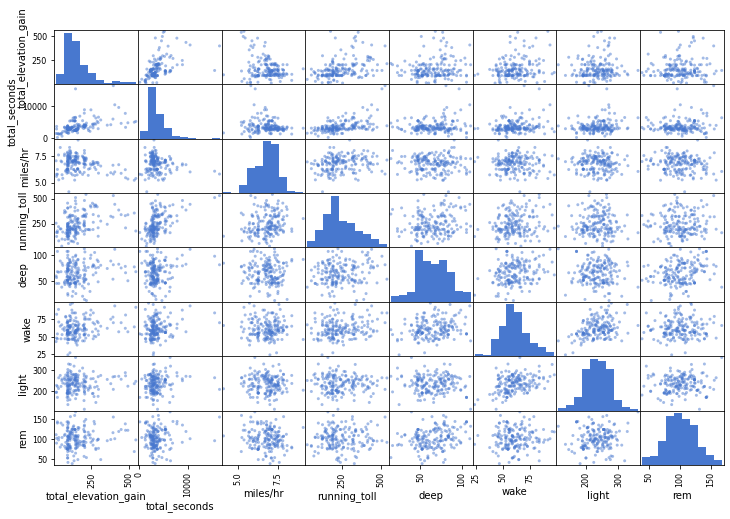

In [23]:
scatter_matrix(strava_handler.df_run[attributes], figsize=(12,8));

In [25]:
y = strava_handler.df_run[['miles/hr']]
X = strava_handler.df_run[['total_elevation_gain','overall_score','resting_heart_rate','running_toll','prev_pace']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=150, test_size=25, random_state=4)

In [35]:
y_test_arr = np.array(y_test['miles/hr'])

Train the multi output regressor random forests and a standard random forest. 

In [29]:
max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))

regr_multirf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=30,
                                                     random_state=0))

In [31]:
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, random_state=2)

In [45]:
rf_accuracy = evaluate(regr_rf, X_test, y_test_arr)
rf_accuracy

Model Performance
Average Error: 0.3816 degrees.
Accuracy = 94.05%.


94.05313118703151

In [46]:
multirf_accuracy = evaluate(regr_multirf, X_test, y_test_arr)
multirf_accuracy

Model Performance
Average Error: 0.7101 degrees.
Accuracy = 88.89%.


88.89143726663711

In [32]:
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

In [57]:
rf_root_mse = np.sqrt(mean_squared_error(y_test_arr, y_rf))
rf_root_mse

0.5055198663035199

In [58]:
mrf_root_mse = np.sqrt(mean_squared_error(y_test_arr, y_multirf))
mrf_root_mse

0.5141664211945348

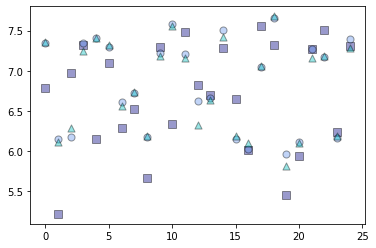

In [37]:
s = 50
a = 0.4
plt.scatter(y=y_test_arr, x=range(0,len(y_test_arr)), edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y=y_multirf,x=range(0,len(y_test_arr)), edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y=y_rf,x=range(0,len(y_test_arr)), edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))

### Fine-tune with RandomizedSearchCV

In [39]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [42]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [47]:
rf = RandomForestRegressor()

In [48]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [50]:
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   50.1s finished


In [51]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [52]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test_arr)

Model Performance
Average Error: 0.3815 degrees.
Accuracy = 93.89%.


In [54]:
random_root_mse = np.sqrt(mean_squared_error(y_test_arr, y_multirf))

In [55]:
random_root_mse

0.5141664211945348